<a href="https://colab.research.google.com/github/radanim/TIL/blob/master/07_stock_price_RNN_output_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RNN 으로 주가예측하기

In [1]:
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional #from 모듈 import 클래스 tf 프레임워크=라이브러리 > keras 패키지 > layers 모듈 > 클래스 . 안에 들어감. 

## 주가수집

In [3]:
# 삼성전자 주가 수집
df = fdr.DataReader("005930","2020")
df.shape

(685, 6)

In [4]:
df.head(2)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435


In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-10-07,55900,56900,55200,56200,16886813,-0.001776
2022-10-11,54400,55700,54000,55500,17422179,-0.012456


## 문제, 답안 나누기

In [6]:
df_ohlcv = df.iloc[:, :-1] # 마지막 컬럼 제외하고 저장

dfx = df_ohlcv.drop(columns ="Close")
dfy = df_ohlcv["Close"]
dfx.shape # 정답(Y) -- close, 훈련(x) - close제외한 나머지

(685, 4)

## 정규화 

In [7]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
# 복원을 위해 x, y 따로 스케일링하기
# 스케일링 후 list 형태로 변환하기
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()
x = mmsx.fit_transform(dfx).tolist()
y = mmsy.fit_transform(dfy.to_frame()).tolist()

In [8]:
len(x[0]), len(y[0])
# (685, 4)      (685, 1)

(4, 1)

## x, y 값 window_size 적용하기


<center>
<img src = "https://i.stack.imgur.com/padg4.gif">
</center>
* 이미지출처: https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn


In [9]:
window_size = 10 
len(y) - window_size

675

In [10]:
# window_size 만큼만 슬라이싱
# 10일치 데이터로 다음날 주가를 예측
# 다음 날 종가(i+windows_size)는 포함되지 않도록 X값을 만들고
# 다음 날 종가를 y로 만듦
window_size = 10 
x_data = []
y_data = []

for i in range(len(y) - window_size):
    _x = x[i : i+window_size]
    _y = y[i + window_size]
    x_data.append(_x)
    y_data.append(_y)

In [11]:
len(x_data), len(y_data)

(675, 675)

## train, test 나누기

In [12]:
# 8:2 로 나누기
split_size = int(len(x_data) * 0.8)
split_size

540

In [13]:
X_train = np.array(x_data[:split_size]) # 80
y_train = np.array(y_data[:split_size]) #80
X_test = np.array(x_data[split_size:]) # 20
y_test = np.array(y_data[split_size:]) #20

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape #(배치사이즈,타임스텝(윈도우 사이즈).피쳐수(칼럼))

((540, 10, 4), (540, 1), (135, 10, 4), (135, 1))

## 모델 생성

In [15]:
data_size = dfx.shape[1]
data_size

4

In [25]:
# 모델 생성

data_size = dfx.shape[1]

model = Sequential()
model.add(LSTM(units=10,activation='relu',return_sequences=True, input_shape=(window_size, data_size)))
model.add(Dropout(0.1)) #10%의 랜덤노드를 날린다. 
model.add(Bidirectional(LSTM(units=10,activation='relu')))
# bidirectional = forward + backward, 실제로 성능차이는 없음
model.add(Dropout(0.1))
model.add(Dense(units=1)) # 분류를 하기 위한 학습
model.summary() 



#배치사이즈는 총 데이터의 개수(로우수), 윈도우 사이즈(현재 정보 기준으로 과거의 정보를 얼마나 반영할지, 타임스탬프), 데이터 사이즈(피쳐수, 칼럼수) 
#None 크기 지정안해줌 어떤 숫자가 들어와도 상관없음. 


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            600       
                                                                 
 dropout (Dropout)           (None, 10, 10)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 20)               1680      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
____________________________________________________

## compile

In [26]:
model.compile(optimizer='adam',loss='mse',metrics=['mse','mae']) #회귀 (y^-y)^2 // 분류 cross categorical entropy (분류값이 얼마나 정확할지를 확률값으로)

## 학습과 예측

In [28]:
X_train.shape,y_train.shape #input sequence length 

((540, 10, 4), (540, 1))

In [34]:
history=model.fit(X_train,y_train,epochs=100,batch_size=30,verbose=1) #메모리 한계 문제를 피하기 위해 배치사이즈를 일부만 선정  verbose=progress바를 그려주나 마나

Epoch 1/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0322
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0343
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0372
Epoch 4/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0347
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0354
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0346
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0319
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0353
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0327
Epoch 10/100
18/18 [=====

In [35]:
history.history

{'loss': [0.0017773404251784086,
  0.002003258792683482,
  0.0022779549472033978,
  0.002156084170565009,
  0.0021320926025509834,
  0.0020947419106960297,
  0.001758216880261898,
  0.0021159907337278128,
  0.0018249923596158624,
  0.0018269653664901853,
  0.001913837855681777,
  0.0020883975084871054,
  0.0016203925479203463,
  0.002115213545039296,
  0.001896302797831595,
  0.0019904037471860647,
  0.0019089904380962253,
  0.0019196011126041412,
  0.0018466392066329718,
  0.0018382437992841005,
  0.00187038560397923,
  0.0020122139248996973,
  0.0018108580261468887,
  0.002081845421344042,
  0.0019703893922269344,
  0.002051157644018531,
  0.0020520854741334915,
  0.0021499120630323887,
  0.0022284137085080147,
  0.0019490240374580026,
  0.001665391493588686,
  0.0018943949835374951,
  0.0019606982823461294,
  0.0020135489758104086,
  0.0017455666093155742,
  0.0019573417957872152,
  0.0018728727009147406,
  0.0020053109619766474,
  0.0019343214808031917,
  0.0019234749488532543,
  0

In [40]:
# y_pred
df_hist=pd.DataFrame(history.history)

In [41]:
df_hist

,loss,mse,mae
0,0.001777,0.001777,0.032242
1,0.002003,0.002003,0.034326
2,0.002278,0.002278,0.037236
3,0.002156,0.002156,0.034718
4,0.002132,0.002132,0.035405
...,...,...,...
95,0.001870,0.001870,0.032208
96,0.001846,0.001846,0.033377
97,0.002128,0.002128,0.034619
98,0.001841,0.001841,0.032781


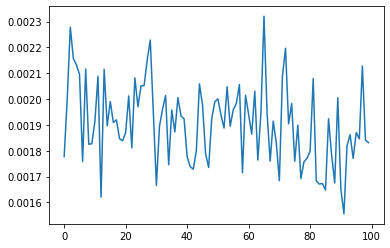

In [42]:
df_hist['loss'].plot()

In [43]:
y_pred=model.predict(X_test)

In [45]:
# rmse
np.sqrt(np.square(y_test-y_pred)).mean()

0.024813435749499665

## 예측 결과 시각화

In [46]:
y_test.shape, y_pred.shape

((135, 1), (135, 1))

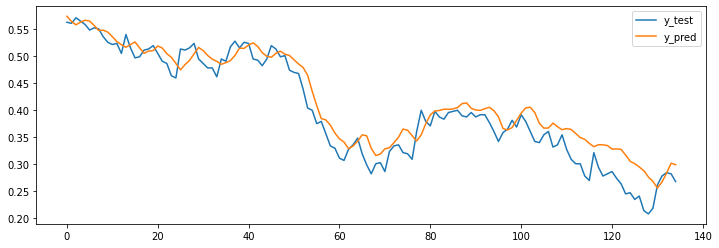

In [50]:
plt.figure(figsize=(12,4))
plt.plot(y_test.flatten(), label='y_test')
plt.plot(y_pred.flatten(), label='y_pred')
plt.legend()

## 원래 값으로 복원하여 비교

In [51]:
y_predict_inverse = mmsy.inverse_transform(y_pred)
y_predict_inverse[:5]

array([[70337.36 ],
       [69877.766],
       [69567.02 ],
       [69806.78 ],
       [69977.3  ]], dtype=float32)

In [52]:
# y_test_inverse
y_test_inverse=mmsy.inverse_transform(y_test)
y_test_inverse[:5]

array([[69800.],
       [69700.],
       [70200.],
       [69900.],
       [69600.]])

In [53]:
# rmse 
np.sqrt(np.square(y_test_inverse-y_predict_inverse).mean()) #예측값이 다른이유? 처음 초기 가중치 값이 랜덤으로 다다르게 들어가서, 똑같게 하려면 랜덤시드 고정 

1514.1574623454358

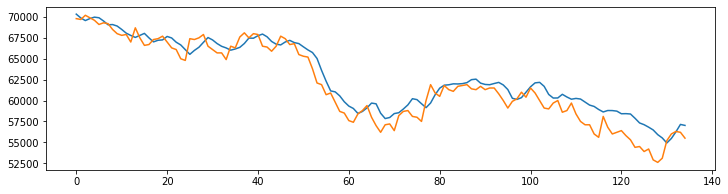

In [54]:
#시각화
plt.figure(figsize=(12,3))
plt.plot(y_predict_inverse)
plt.plot(y_test_inverse)